Destroyed GC Mass Contribution

In [2]:
import json

import agama
import halo_analysis as halo
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gc_utils import iteration_name, snapshot_name  # type: ignore
from scipy.interpolate import interp1d, PchipInterpolator

In [3]:
sim = "m12i"

data_dir = "/Users/z5114326/Documents/GitHub/gc_statistics/data/"
data_file = data_dir + "m12i_time_dep.json"

sim_dir = "/Users/z5114326/Documents/simulations/"
pot_dir = "/Users/z5114326/Documents/GitHub/gc_kinematics/data/potentials/"

fire_dir = sim_dir + sim + "/" + sim + "_res7100/"

proc_file = sim_dir + sim + "/" + sim + "_processed.hdf5"
proc_data = h5py.File(proc_file, "r")  # open processed data file

pub_data = sim_dir + "snapshot_times_public.txt"

agama.setUnits(mass=1, length=1, velocity=1)

with open(data_file, "r") as file:
    data_dict = json.load(file)

snap_time_pub = pd.read_table(pub_data, comment="#", header=None, sep=r"\s+")
snap_time_pub.columns = [
    "index",
    "scale_factor",
    "redshift",
    "time_Gyr",
    "lookback_time_Gyr",
    "time_width_Myr",
]

In [ ]:
mass_dict = {}
# snap_data = proc_data[it_id]["snapshots"]

it_min = 0
it_max = 100
for it in range(it_min, it_max + 1):
    it_id = iteration_name(it)
    mass_dict[it_id] = {}
    snap_keys = proc_data[it_id]["snapshots"]

    surviving_gc_lst = np.array(proc_data[it_id]["snapshots"]["snap600"]["gc_id"])

    for snap_id in snap_keys:
        snap_data = snap_keys[snap_id]

        mass_dict[it_id][snap_id] = {}

        mass_dict[it_id][snap_id]["insitu_surv"] = {}
        mass_dict[it_id][snap_id]["insitu_surv"]["mass"] = []
        mass_dict[it_id][snap_id]["insitu_surv"]["gc_id"] = []

        mass_dict[it_id][snap_id]["insitu_dead"] = {}
        mass_dict[it_id][snap_id]["insitu_dead"]["mass"] = []
        mass_dict[it_id][snap_id]["insitu_dead"]["gc_id"] = []

        mass_dict[it_id][snap_id]["exsitu_surv"] = {}
        mass_dict[it_id][snap_id]["exsitu_surv"]["mass"] = []
        mass_dict[it_id][snap_id]["exsitu_surv"]["gc_id"] = []

        mass_dict[it_id][snap_id]["exsitu_dead"] = {}
        mass_dict[it_id][snap_id]["exsitu_dead"]["mass"] = []
        mass_dict[it_id][snap_id]["exsitu_dead"]["gc_id"] = []

        if "bound_flag" in snap_data.keys():
            for gc, grp, mass, bnd in zip(
                snap_data["gc_id"], snap_data["group_id"], snap_data["mass"], snap_data["bound_flag"]
            ):
                if bnd == 1:
                    if grp == 0:
                        if gc in surviving_gc_lst:
                            mass_dict[it_id][snap_id]["insitu_surv"]["mass"].append(mass)
                            mass_dict[it_id][snap_id]["insitu_surv"]["gc_id"].append(gc)
                        else:
                            mass_dict[it_id][snap_id]["insitu_dead"]["mass"].append(mass)
                            mass_dict[it_id][snap_id]["insitu_dead"]["gc_id"].append(gc)

                    if grp > 0:
                        if gc in surviving_gc_lst:
                            mass_dict[it_id][snap_id]["exsitu_surv"]["mass"].append(mass)
                            mass_dict[it_id][snap_id]["exsitu_surv"]["gc_id"].append(gc)
                        else:
                            mass_dict[it_id][snap_id]["exsitu_dead"]["mass"].append(mass)
                            mass_dict[it_id][snap_id]["exsitu_dead"]["gc_id"].append(gc)

        else:
            for gc, grp, mass in zip(snap_data["gc_id"], snap_data["group_id"], snap_data["mass"]):
                if grp == 0:
                    if gc in surviving_gc_lst:
                        mass_dict[it_id][snap_id]["insitu_surv"]["mass"].append(mass)
                        mass_dict[it_id][snap_id]["insitu_surv"]["gc_id"].append(gc)
                    else:
                        mass_dict[it_id][snap_id]["insitu_dead"]["mass"].append(mass)
                        mass_dict[it_id][snap_id]["insitu_dead"]["gc_id"].append(gc)

                if grp > 0:
                    if gc in surviving_gc_lst:
                        mass_dict[it_id][snap_id]["exsitu_surv"]["mass"].append(mass)
                        mass_dict[it_id][snap_id]["exsitu_surv"]["gc_id"].append(gc)
                    else:
                        mass_dict[it_id][snap_id]["exsitu_dead"]["mass"].append(mass)
                        mass_dict[it_id][snap_id]["exsitu_dead"]["gc_id"].append(gc)

In [5]:
# Collect all unique time stamps across iterations
snap_set = set()

for it in range(it_min, it_max + 1):
    it_id = iteration_name(it)
    snap_set.update(mass_dict[it_id].keys())

snap_lst = sorted(snap_set)

comp_mass_dict = {}
comp_mass_dict["snap_lst"] = snap_lst

for it in range(it_min, it_max + 1):
    it_id = iteration_name(it)
    src_data = proc_data[it_id]["source"]
    src_gc_lst = np.array(src_data["gc_id"])
    src_an_lst = np.array(src_data["analyse_flag"])

    comp_mass_dict[it_id] = {}

    # in situ survive
    comp_mass_dict[it_id]["insitu_surv"] = []
    for i in range(1, len(snap_lst)):
        pst_snap_id = snap_lst[i - 1]
        pst_gc_lst = mass_dict[it_id][pst_snap_id]["insitu_surv"]["gc_id"]
        pst_mass_lst = mass_dict[it_id][pst_snap_id]["insitu_surv"]["mass"]

        cur_snap_id = snap_lst[i]
        cur_gc_lst = mass_dict[it_id][cur_snap_id]["insitu_surv"]["gc_id"]
        cur_mass_lst = mass_dict[it_id][cur_snap_id]["insitu_surv"]["mass"]

        partial_mass_loss_lst = []
        for c_gc, c_mass_log in zip(cur_gc_lst, cur_mass_lst):
            # if gc not in past list then get its mass at formation
            if c_gc not in pst_gc_lst:
                idx = np.where((src_gc_lst == c_gc) & (src_an_lst == 1))[0][0]
                pst_mass_log = src_data["logm_tform"][idx]
                pst_mass = 10**pst_mass_log

            else:
                idx = np.where(pst_gc_lst == c_gc)[0][0]
                pst_mass_log = pst_mass_lst[idx]
                pst_mass = 10**pst_mass_log

            c_mass = 10**c_mass_log
            partial_mass_loss_lst.append(pst_mass - c_mass)

        full_mass_loss_lst = []
        # if gc from past list is not in current list then it has fully been disrupted
        for p_gc, p_mass_log in zip(pst_gc_lst, pst_mass_lst):
            if p_gc not in cur_gc_lst:
                pst_mass = 10**p_mass_log
                full_mass_loss_lst.append(pst_mass)

        comp_mass_dict[it_id]["insitu_surv"].append(
            np.sum(partial_mass_loss_lst) + np.sum(full_mass_loss_lst)
        )

    # in situ dead
    comp_mass_dict[it_id]["insitu_dead"] = []
    for i in range(1, len(snap_lst)):
        pst_snap_id = snap_lst[i - 1]
        pst_gc_lst = mass_dict[it_id][pst_snap_id]["insitu_dead"]["gc_id"]
        pst_mass_lst = mass_dict[it_id][pst_snap_id]["insitu_dead"]["mass"]

        cur_snap_id = snap_lst[i]
        cur_gc_lst = mass_dict[it_id][cur_snap_id]["insitu_dead"]["gc_id"]
        cur_mass_lst = mass_dict[it_id][cur_snap_id]["insitu_dead"]["mass"]

        partial_mass_loss_lst = []
        for c_gc, c_mass_log in zip(cur_gc_lst, cur_mass_lst):
            # if gc not in past list then get its mass at formation
            if c_gc not in pst_gc_lst:
                idx = np.where((src_gc_lst == c_gc) & (src_an_lst == 1))[0][0]
                pst_mass_log = src_data["logm_tform"][idx]
                pst_mass = 10**pst_mass_log

            else:
                idx = np.where(pst_gc_lst == c_gc)[0][0]
                pst_mass_log = pst_mass_lst[idx]
                pst_mass = 10**pst_mass_log

            c_mass = 10**c_mass_log
            partial_mass_loss_lst.append(pst_mass - c_mass)

        full_mass_loss_lst = []
        for p_gc, p_mass_log in zip(pst_gc_lst, pst_mass_lst):
            # if gc from past list is not in current list then it has fully been disrupted
            if p_gc not in cur_gc_lst:
                pst_mass = 10**p_mass_log
                full_mass_loss_lst.append(pst_mass)

        comp_mass_dict[it_id]["insitu_dead"].append(
            np.sum(partial_mass_loss_lst) + np.sum(full_mass_loss_lst)
        )

    # ex situ survive
    comp_mass_dict[it_id]["exsitu_surv"] = []
    for i in range(1, len(snap_lst)):
        pst_snap_id = snap_lst[i - 1]
        pst_gc_lst = mass_dict[it_id][pst_snap_id]["exsitu_surv"]["gc_id"]
        pst_mass_lst = mass_dict[it_id][pst_snap_id]["exsitu_surv"]["mass"]

        cur_snap_id = snap_lst[i]
        cur_gc_lst = mass_dict[it_id][cur_snap_id]["exsitu_surv"]["gc_id"]
        cur_mass_lst = mass_dict[it_id][cur_snap_id]["exsitu_surv"]["mass"]

        partial_mass_loss_lst = []
        for c_gc, c_mass_log in zip(cur_gc_lst, cur_mass_lst):
            # if gc not in past list then mass at current snapshot is the mass closest to post accretion
            if c_gc not in pst_gc_lst:
                pst_mass_log = c_mass_log
                pst_mass = 10**pst_mass_log

            else:
                idx = np.where(pst_gc_lst == c_gc)[0][0]
                pst_mass_log = pst_mass_lst[idx]
                pst_mass = 10**pst_mass_log

            c_mass = 10**c_mass_log
            partial_mass_loss_lst.append(pst_mass - c_mass)

        full_mass_loss_lst = []
        for p_gc, p_mass_log in zip(pst_gc_lst, pst_mass_lst):
            # if gc from past list is not in current list then it has fully been disrupted
            if p_gc not in cur_gc_lst:
                pst_mass = 10**p_mass_log
                full_mass_loss_lst.append(pst_mass)

        comp_mass_dict[it_id]["exsitu_surv"].append(
            np.sum(partial_mass_loss_lst) + np.sum(full_mass_loss_lst)
        )

    # ex situ dead
    comp_mass_dict[it_id]["exsitu_dead"] = []
    for i in range(1, len(snap_lst)):
        pst_snap_id = snap_lst[i - 1]
        pst_gc_lst = mass_dict[it_id][pst_snap_id]["exsitu_dead"]["gc_id"]
        pst_mass_lst = mass_dict[it_id][pst_snap_id]["exsitu_dead"]["mass"]

        cur_snap_id = snap_lst[i]
        cur_gc_lst = mass_dict[it_id][cur_snap_id]["exsitu_dead"]["gc_id"]
        cur_mass_lst = mass_dict[it_id][cur_snap_id]["exsitu_dead"]["mass"]

        partial_mass_loss_lst = []
        for c_gc, c_mass_log in zip(cur_gc_lst, cur_mass_lst):
            # if gc not in past list then mass at current snapshot is the mass closest to post accretion
            if c_gc not in pst_gc_lst:
                pst_mass_log = c_mass_log
                pst_mass = 10**pst_mass_log

            else:
                idx = np.where(pst_gc_lst == c_gc)[0][0]
                pst_mass_log = pst_mass_lst[idx]
                pst_mass = 10**pst_mass_log

            c_mass = 10**c_mass_log
            partial_mass_loss_lst.append(pst_mass - c_mass)

        full_mass_loss_lst = []
        for p_gc, p_mass_log in zip(pst_gc_lst, pst_mass_lst):
            # if gc from past list is not in current list then it has fully been disrupted
            if p_gc not in cur_gc_lst:
                pst_mass = 10**p_mass_log
                full_mass_loss_lst.append(pst_mass)

        comp_mass_dict[it_id]["exsitu_dead"].append(
            np.sum(partial_mass_loss_lst) + np.sum(full_mass_loss_lst)
        )

In [6]:
def safe_interpolate(x, y, test_grid):
    interp_func = interp1d(x, y, kind="linear", bounds_error=False, fill_value=(0, 1))
    return interp_func(test_grid)

In [28]:
times = []
for snap_id in snap_lst:
    snap = int(snap_id[4:])
    idx = np.where(snap_time_pub["index"] == snap)[0][0]
    times.append(snap_time_pub["time_Gyr"][idx])

times = times[1:]

# t_grid = np.linspace(np.min(times), np.max(times), 1000)
t_grid = np.linspace(0, np.max(times), 1000)

insitu_surv_lst = []
insitu_dead_lst = []
exsitu_surv_lst = []
exsitu_dead_lst = []

for it in range(it_min, it_max + 1):
    # for it in range(0, 1):
    it_id = iteration_name(it)
    insitu_surv_lst.append(safe_interpolate(times, np.cumsum(comp_mass_dict[it_id]["insitu_surv"]), t_grid))
    insitu_dead_lst.append(safe_interpolate(times, np.cumsum(comp_mass_dict[it_id]["insitu_dead"]), t_grid))

    exsitu_surv_lst.append(safe_interpolate(times, np.cumsum(comp_mass_dict[it_id]["exsitu_surv"]), t_grid))
    exsitu_dead_lst.append(safe_interpolate(times, np.cumsum(comp_mass_dict[it_id]["exsitu_dead"]), t_grid))

# Convert lists to arrays
insitu_surv_arr = np.array(insitu_surv_lst)
insitu_dead_arr = np.array(insitu_dead_lst)
exsitu_surv_arr = np.array(exsitu_surv_lst)
exsitu_dead_arr = np.array(exsitu_dead_lst)

# Compute mean and standard deviation
avg_insitu_surv = np.mean(insitu_surv_arr, axis=0)
std_insitu_surv = np.std(insitu_surv_arr, axis=0)

avg_insitu_dead = np.mean(insitu_dead_arr, axis=0)
std_insitu_dead = np.std(insitu_dead_arr, axis=0)

avg_exsitu_surv = np.mean(exsitu_surv_arr, axis=0)
std_exsitu_surv = np.std(exsitu_surv_arr, axis=0)

avg_exsitu_dead = np.mean(exsitu_dead_arr, axis=0)
std_exsitu_dead = np.std(exsitu_dead_arr, axis=0)

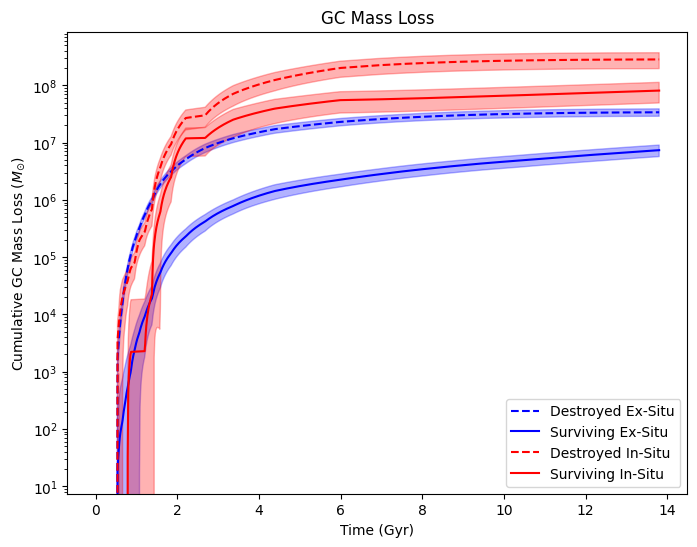

In [29]:
# Plot mean CDF with error regions
plt.figure(figsize=(8, 6))


plt.plot(t_grid, avg_exsitu_dead, label="Destroyed Ex-Situ", c="blue", ls="--")
plt.fill_between(
    t_grid,
    avg_exsitu_dead - std_exsitu_dead,
    avg_exsitu_dead + std_exsitu_dead,
    color="blue",
    alpha=0.3,
)

plt.plot(t_grid, avg_exsitu_surv, label="Surviving Ex-Situ", c="blue", ls="-")
plt.fill_between(
    t_grid,
    avg_exsitu_surv - std_exsitu_surv,
    avg_exsitu_surv + std_exsitu_surv,
    color="blue",
    alpha=0.3,
)

plt.plot(t_grid, avg_insitu_dead, label="Destroyed In-Situ", c="red", ls="--")
plt.fill_between(
    t_grid,
    avg_insitu_dead - std_insitu_dead,
    avg_insitu_dead + std_insitu_dead,
    color="red",
    alpha=0.3,
)

plt.plot(t_grid, avg_insitu_surv, label="Surviving In-Situ", c="red", ls="-")
plt.fill_between(
    t_grid,
    avg_insitu_surv - std_insitu_surv,
    avg_insitu_surv + std_insitu_surv,
    color="red",
    alpha=0.3,
)

plt.yscale("log")
plt.xlabel("Time (Gyr)")
plt.ylabel(r"Cumulative GC Mass Loss ($M_{\odot}$)")
plt.title("GC Mass Loss")
plt.legend(loc="lower right")
# plt.ylim((10**2, 10**9))

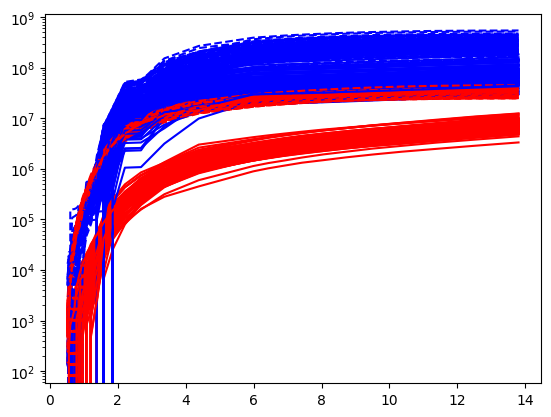

In [30]:
for it in range(it_min, it_max + 1):
    it_id = iteration_name(it)

    plt.plot(times, np.cumsum(comp_mass_dict[it_id]["insitu_surv"]), c="b", ls="-")
    plt.plot(times, np.cumsum(comp_mass_dict[it_id]["insitu_dead"]), c="b", ls="--")

    plt.plot(times, np.cumsum(comp_mass_dict[it_id]["exsitu_surv"]), c="r", ls="-")
    plt.plot(times, np.cumsum(comp_mass_dict[it_id]["exsitu_dead"]), c="r", ls="--")

plt.yscale("log")

In [49]:
comp_mass_dict["it000"]["exsitu_surv"][-1], comp_mass_dict["it000"]["exsitu_dead"][-1]

(1621.4156961755584, 0.0)